# Mini Gato

Goals:

- Simplicity
- Minimal dependencies
- Clear explanations
- Quickly iterable executable examples
- Extensible architecture

Non-goals:

- Performance
- Eval metrics

If I succeed at the goals then I expect the path towards the non-goals will be clear.

# Text

To accomplish our goals, we need a small dataset with samples that are easy to understand. I want it to be obvious how well things are working when we run quick sanity checks.

Shakespeare fits. There's enough data to usefully train, it's small enough to download and prepare quickly, and it will be easy to do a sanity-check human-eval on the output to know how good we're doing.

To accomplish the goal of minimal dependencies and clear explanations, we'll grab the dataset in its raw format. We _could_ get the same dataset from a model hub, like HuggingFace. But this is a perfect time to demonstrate how you would turn raw data into a useful dataset.

In the [words of Karpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data):

> Become one with the data.

Take a look at the [raw data](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) so you know what we're working with.

The raw data is just 40,000 lines in a single text file.

> ANTONIO:
> We two, my lord,
> Will guard your person while you take your rest,
> And watch your safety.
> 
> ALONSO:
> Thank you. Wondrous heavy.
> 
> SEBASTIAN:
> What a strange drowsiness possesses them!
> 
> ANTONIO:
> It is the quality o' the climate.
> 
> SEBASTIAN:
> Why
> Doth it not then our eyelids sink? I find not
> Myself disposed to sleep.

Each character's lines are separated by an empty line.

Here, we face a common question.

**How do we transform this data into samples that can be input to a model?**

You'll face this question with almost every raw dataset that you prepare. There's no _right_ answer. You could treat every line as a sample. You could treat every sample [as a sequence of 3 characters](https://youtu.be/TCH_1BHY58I?t=587). You could split on paragraph (or in the case of a Shakespear play, a scene). Or anything else. The only constraint is your samples are small enough to fit the input dimensions of your model.

We want our training data to have a long enough context to learn from entire conversations of multiple characters. So, we don't want our DataLoader to return samples of 1 character speaking. That would be too short.

I suggest we split on each character's lines and then take a number of character's lines in sequence until we have more than ~250 words. That ought to play nicely with a sequence length of 512. And if we want to play with smaller sequence lengths, we can always truncate. (And larger sequence lengths we'll just pad.)

In [75]:
import os
from pathlib import Path
import re
import tempfile
import requests

def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [76]:
text_dataset = acquire_shakespeare_dataset()

In [77]:
print(f"Number of samples in the dataset: {len(text_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in text_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{text_dataset[0][:80]}")

Number of samples in the dataset: 7184
Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


## Tokenize text

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream. Below we report the tokenization scheme we found to produce the best results for Gato at the current scale using contemporary hardware and model architectures.
> Text is encoded via SentencePiece (Kudo & Richardson, 2018) with 32000 subwords into the integer range [0, 32000).
> ...

For this example, we'll use GPT2. The only thing to note as you change tokenizers is that discrete/continuous values get tokenized to the 1024 numbers after the vocab size (32000 to 33024 in the case of SentencePiece). So, you'll need to make that update as you change tokenizers.

GPT2 has a vocab size of 50256, so our discrete/continuous values will tokenize to the range 50256 to 51280.

In [4]:
import torch
from transformers import GPT2Tokenizer

In [5]:
# Prefixing with _ to signify global.
_text_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2", clean_up_tokenization_spaces=True)
_text_tokenizer.pad_token = _text_tokenizer.eos_token
tokenize_text = _text_tokenizer

### Context length

All modalities must share the same context length. We'll have to decide what that is now, since we're starting on our first modality, text.

Text is easy, because the text we train on will usually have a lot more than 1024 tokens of context, and truncating won't affect the quality of the context.

But when we get to things like videos/images/robotics, it might be hard to fit a single "episode" into a small context. Each image of a video might take up hundreds of tokens, leaving us room for only 2 or 3 images in a single training example (with the remaining tokens taken up by other forms of observation, like proprioception input).

I'll arbitrarily pick 1024 as a context window for now.

In [6]:
SEQUENCE_LENGTH = 1024
BATCH_SIZE=3

In [7]:
text_batch = tokenize_text(text_dataset[:BATCH_SIZE], max_length=SEQUENCE_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
text_batch["input_ids"].shape, text_batch["attention_mask"].shape

(torch.Size([3, 1024]), torch.Size([3, 1024]))

## Embed text

What size should our embedding dimension be?

We could almost pick any arbitrary number here. Karpathy has [a reference in his minGPT repo that says GPT2 used 768 dimensions](https://github.com/karpathy/minGPT/blob/37baab71b9abea1b76ab957409a1cc2fbfba8a26/mingpt/model.py#L131).

Pick too large of a number and you'll run into resource bottlenecks. I tried with 768 dimensions and it seemed to be a bit too much for my machine.

W're actually a bit constricted in our choices. We can't choose any arbitrary number. We're restricted by requirements of the image modality. How are we going to embed _images_? We're going to split the image into a grid of $n$ by $m$ patches (each with 3 color channels). Therefore, our embedding needs to be $3 * n * m$. 12 by 12 seemed to be a sweet spot in my experiments. So, 432 dimensions.

In [125]:
import torch.nn as nn

In [126]:
EMBEDDING_DIM = 432

In [127]:
_text_embedding = nn.Embedding(_text_tokenizer.vocab_size, EMBEDDING_DIM)
embed_text = _text_embedding

## Sequence text

"Sequencing" our data samples is going to be the hardest part of Gato.

It's really simple for text. You just input the words into the model in the order that they appear in the text.

But what sequence would you use for a robot task, where there's a single text description of the objective, a sequence of images, and a sequence of proprioceptions?

Because it's going to get so complex for later modalities, expect to see more interesting "Sequence text" headings in the future.

In [129]:
def sequence_text(tokenizer, embedder, max_length, batch):
    tokens = tokenizer(batch, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    ys = tokens["input_ids"].clone()[:, 1:]
    embedding = embedder(tokens["input_ids"][:, :-1])
    return embedding, ys, tokens["attention_mask"][:, :-1]

In [130]:
from torch.utils.data import DataLoader, Dataset
from functools import partial

In [131]:
_text_tokenizer(next(iter(DataLoader(text_dataset, batch_size=BATCH_SIZE))));

## Text DataLoader

Above, we wrote all of our utilities for tokenizing, embedding, and sequencing text.

How do we combine all of those utilities?

Honestly, it doesn't much matter _how_ you combine them. The important thing is that the model gets:

1. input embeddings
2. output target
3. mask

The reason it's so important that the model get the embeddings (rather than input at some stage pre-embedding) is that:

- the Gato architecture has many complexities in how it sequences different modalities
- datasets have wild variations in their structure and data types

If you try to deal with data _inside_ the Gato model, then you're left with a tangled mess of conditionals.

If you enforce a standard at the input boundary, then the code to wrangle each dataset is isolated in it's own tinly little tangled mess which doesn't affect the rest of the datasets or the model.

The only "gotcha" to remember about this: your embedding dimensions won't be part of an `nn.Module`. You'll have to remember to tell your optimizer about them.

In [133]:
text_dataloader = map(
    partial(sequence_text, tokenize_text, _text_embedding, SEQUENCE_LENGTH),
    DataLoader(text_dataset, batch_size=BATCH_SIZE)
)
text_xs, text_ys, text_mask = next(iter(text_dataloader))

In [134]:
text_xs.shape, text_ys.shape, text_mask.shape

(torch.Size([3, 1023, 432]), torch.Size([3, 1023]), torch.Size([3, 1023]))

# VQA

Unlike text, it's hard to get a small and simple dataset for visual question answering.

The [OK-VQA dataset](https://okvqa.allenai.org/index.html) has 14,055 `(image, question, answer)` tuples (along with some other data, like a confidence rating in the answer, and multiple answers where the question is ambiguous).

That's not _huge_. But it's kind of nice to be able to really quickly _overfit_ when you're first experimenting with these models. Pursposefully overfitting is a good sanity check. If you can't overfit, then you _definitely_ can't _fit_...

So, let's use something smaller than [OK-VQA](https://okvqa.allenai.org/index.html).

Let's use [eihli/micro-ok-vqa](https://huggingface.co/datasets/eihli/micro-ok-vqa), and see if we can overfit. It's just the first 100 images from OK-VQA. 80 train, 20 validation.

In [137]:
import random
import datasets
import torchvision.transforms.v2 as transforms

In [138]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("pt")

Once again, in the [words of Karpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data):

> Become one with the data.

In [141]:
vqa_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 20
    })
})

In [142]:
vqa_dataset["train"]

Dataset({
    features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
    num_rows: 80
})

In [22]:
vqa_dataset['train']['image'][0].shape

torch.Size([3, 479, 640])

In [143]:
vqa_dataset["train"]["question"][:5]

['What is the hairstyle of the blond called?',
 'How old do you have to be in canada to do this?',
 'Can you guess the place where the man is playing?',
 'Which rail company is named after a town in new mexico?',
 'Is the boy swimming or doing another water activity?']

In [144]:
len(vqa_dataset["train"]["answers"][0]), vqa_dataset["train"]["answers"][0][:3]

(10,
 [{'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(1)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(2)},
  {'answer': 'pony tail',
   'raw_answer': 'pony tail',
   'answer_confidence': 'yes',
   'answer_id': tensor(3)}])

This is the kind of one-off work you'll encounter for each dataset.

This particular VQA dataset offers 10 possible answers for each question. I assume the idea is that some image questions are ambiguous.

Part of our work is deciding how we want to handle that.

In the grand scheme of this model, I don't think there's a reasonable decision we could make here that would result in a significant change to the model quality.

My plan is to just randomly select an answer and ignore the "answer_confidence" value.

In [140]:
micro_ok_vqa_transform = transforms.Compose([
    # No particular reason to use `transforms.Compose` here since we're only doing one transform. But it's nice to know about.
    transforms.RandomResizedCrop((192, 192), (0.5, 1.0)),
])

In [23]:
def micro_ok_vqa_collate_fn(batch):
    answers = [random.choice(el["answers"])["answer"] for el in batch]
    questions = [el["question"] for el in batch]
    images = torch.stack([micro_ok_vqa_transform(el["image"]) for el in batch])
    return {
        "question": questions,
        "image": images,
        "answer": answers,
    }

In [145]:
vqa_dl = DataLoader(vqa_dataset["train"], batch_size=8, collate_fn=micro_ok_vqa_collate_fn)
vqa_batch = next(iter(vqa_dl))

In [146]:
vqa_batch["image"].shape

torch.Size([8, 3, 192, 192])

In [147]:
import matplotlib.pyplot as plt

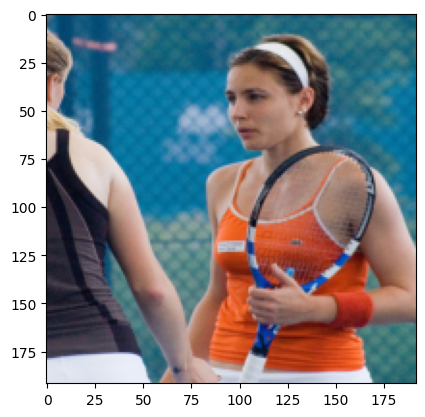

In [148]:
plt.imshow(vqa_batch["image"][0].permute(1, 2, 0))

### Tokenizing images

Sweet.

Now.

How do we tokenize images?

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

We'll use 12 by 12 to keep our model a bit smaller and faster.

Note that even though we're encoding text (the question and answer), we can't simply re-use the `tokenize_text` function that we used previously, because that function assumed the text was taking up the entire context window. The question and answer will only take up a small portion of the context window in the VQA case. The image will take up a large portion.

In [149]:
images = vqa_batch["image"]
images.shape

torch.Size([8, 3, 192, 192])

In [150]:
from einops import rearrange

In [151]:
patch_size=12

In [152]:
patches = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([8, 256, 432])

In [153]:
reconstructed = rearrange(patches, 'b (ph pw) (sh sw c) -> b c (ph sh) (pw sw)', ph=16, pw=16, sh=patch_size, sw=patch_size)
reconstructed.shape

torch.Size([8, 3, 192, 192])

In [154]:
(reconstructed == images).all()

tensor(True)

In [155]:
def images_to_patches(images, patch_size=12):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)

# We don't need this as part of Gato. It's just here to play with and visually test the code.
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches, 
        'b (ph pw) (c ps1 ps2) -> b c (ph ps1) (pw ps2)',
        ph=patch_height,
        pw=patch_width,
        ps1=patch_size,
        ps2=patch_size,
    )
    return reconstructed

In [156]:
# And to prove that we can go from image -> patch -> image
recovered_images = patches_to_image(images_to_patches(images), (3, 192, 192))
(recovered_images == images).all()

tensor(True)

Other than patching, is there anything else?

> Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

How do we normalize?

How do we normalize along the _patch_ dimension?

Let's first handle normalizing a rank one tensor. Then, we'll write a helper utility to apply that kind of function across any arbitrary dimension.

In [161]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [162]:
normalize_to_between_minus_one_plus_one(torch.arange(6))

tensor([-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000])

In [163]:
# There's a small deviation in the NEKO codebase from the paper.
# The paper normalizes _per patch_. The NEKO codebase currently normalizes _per image_.
# https://github.com/eihli/NEKO/blob/master/gato/policy/embeddings.py#L38
# This notebook normalizeds per patch. That's what this utility helps.
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

And here's a simple sanity check. I'll pick some data that's simple to reason about and I'll pick some operations that will highlight the effects of the code.

In [167]:
example = torch.arange(12).view(3, 2, 2)
print(f"starting tensor:\n{example}\n")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}\n")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}\n")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}\n")

starting tensor:
tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]]])

t * t.min() along dim 0:
tensor([[[ 0,  1],
         [ 4,  9]],

        [[ 0,  5],
         [12, 21]],

        [[ 0,  9],
         [20, 33]]])

t * t.min() along dim 1:
tensor([[[ 0,  1],
         [ 0,  3]],

        [[16, 25],
         [24, 35]],

        [[64, 81],
         [80, 99]]])

t * t.min() along dim 2:
tensor([[[  0,   0],
         [  4,   6]],

        [[ 16,  20],
         [ 36,  42]],

        [[ 64,  72],
         [100, 110]]])



In [168]:
def tokenize_image(image: torch.Tensor) -> torch.Tensor:
    """Convert images to patches, normalize each patch, then prepare it for
    embedding by reshaping to CxHxW so that we can send it through the conv
    layers of a ResNet block.
    """ 
    image = images_to_patches(image)
    # Hardcoding as a reminder to do something smarter
    SQUARE_ROOT_OF_PATCH_SIZE = 3.464
    image = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 2, image
        )
        / SQUARE_ROOT_OF_PATCH_SIZE
    )
    return image

In [169]:
vqa_batch["image_tokens"] = tokenize_image(vqa_batch["image"])

In [170]:
vqa_batch["image_tokens"].shape

torch.Size([8, 256, 432])

### Image Embedding

> 2.2 Embedding input tokens and setting output targets
> 
> After tokenization and sequencing, we apply a parameterized embedding function f (·; θe) to each token (i.e. it is applied to both observations and actions) to produce the final model input. To enable efficient learning from our multi-modal input sequence s1:L the embedding function performs different operations depending on the modality the token stems from...
> 
> Tokens belonging to image patches for any time-step are embedded using a single ResNet (He et al., 2016a) block to obtain a vector per patch. For image patch token embeddings, we also add a learnable within-image position encoding vector.

A single ResNet block. Ok. Easy.

In [47]:
import torch.nn as nn

In [48]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

_image_embedding = ResNetV2Block(3, EMBEDDING_DIM)
# This _position_embedding doesn't match exactly what's in the Gato paper.
# The gato/policy/embeddings.py file has the exact implementation from the paper.
# https://github.com/eihli/NEKO/blob/explore-simplify-dataset-dataloader/gato/policy/embeddings.py#L91
_position_embedding = nn.Embedding(256, EMBEDDING_DIM)

In [49]:
# TODO: This isn't how Gato does position embeddings.
# See Figure 17.
# I think their idea is that they want a separate row and column position embedding.
# Is that needed? My idea is that the embedding table would learn to distinguish that itself.
# Maybe their's generalizes better with less data?
def embed_image(image_tokens):
    return _image_embedding(image_tokens) + _position_embedding(torch.arange(256))

In [50]:
_text_tokenizer.bos_token

'<|endoftext|>'

In [51]:
# For simplicity, I'm hardcoding a few important decisions in this function.
# Given any particular context window:
# - What should be the max token length of the question?
# - What should be the max token length of the answer?
# 
# I'm assuming a context window of 1024 and image sizes of (3, 192, 192) split into 16x16 patches of 12x12,
# resulting in 256 image tokens and 756 remaining tokens to distribute to the question and answer.
# I assume the question is usually longer, so I'm rather arbitrarily picking 512 tokens for the question
# and 256 for the answer.
def sequence_vqa(text_tokenizer, text_embedder, image_tokenizer, image_embedder, batch):
    bos_token = text_tokenizer.bos_token
    eos_token = text_tokenizer.eos_token
    question_max_length = 512
    answer_max_length = 256
    
    question = [bos_token + q + eos_token for q in batch["question"]]
    question_tokens = text_tokenizer(
        question, 
        truncation=True, 
        padding="max_length", 
        # max_length+1 because we're taking data[:-1] for xs and data[1:] for ys.
        max_length=question_max_length+1,
        return_tensors="pt"
    )

    # If the answer isn't in the batch, then we consider ourselves in "prediction" mode
    # and just start with a bos_token.
    if "answer" not in batch:
        answer = [bos_token for _ in question]
    else:
        # This bos + text + eos preprocessing might be cleaner in its own preprocessing step
        # rather than clump it all inside the `sequence_...` function.
        answer = [bos_token + a + eos_token for a in batch["answer"]]
    answer_tokens = text_tokenizer(
        answer, 
        truncation=True, 
        padding="max_length", 
        max_length=answer_max_length+1, 
        return_tensors="pt"
    )
    
    image_tokens = image_tokenizer(batch["image"])
    # We're not predicting image tokens, so we need to return a mask that our loss function can 
    # use to ignore them.
    image_attention_mask = torch.zeros_like(image_tokens)

    question_embedding = text_embedder(question_tokens["input_ids"][:, :-1])
    answer_embedding = text_embedder(answer_tokens["input_ids"][:, :-1])
    image_embedding = image_embedder(image_tokens)
    xs = torch.concat([question_embedding, image_embedding, answer_embedding], dim=1)
    ys = torch.concat([question_tokens["input_ids"][:, 1:], torch.zeros(image_tokens.shape[:2]), answer_tokens["input_ids"][:, 1:]], dim=1).int()
    attention_mask = torch.concat([question_tokens["attention_mask"][:, :-1], torch.zeros(image_tokens.shape[:2]), answer_tokens["attention_mask"][:, :-1]], dim=1)
    return xs, ys, attention_mask

In [57]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("torch")
vqa_dataloader = map(
    partial(sequence_vqa, tokenize_text, embed_text, tokenize_image, embed_image), 
    DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)
)
xs, ys, mask = next(vqa_dataloader)

In [58]:
xs.shape, ys.shape, mask.shape, ys.dtype

(torch.Size([3, 1024, 432]),
 torch.Size([3, 1024]),
 torch.Size([3, 1024]),
 torch.int32)

In [59]:
text_xs.shape, text_ys.shape, text_mask.shape, text_ys.dtype

(torch.Size([3, 1023, 432]),
 torch.Size([3, 1023]),
 torch.Size([3, 1023]),
 torch.int64)

# Loss

In [60]:
import torch.nn.functional as F

In [61]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / mask.sum()
    return loss

# Training

In [62]:
from transformers import GPT2TokenizerFast, GPT2Config, GPT2Model

In [63]:
device = torch.device('cuda')

In [64]:
def init_model():
    configuration = GPT2Config(
        n_layer=2,
        n_head=2,
        n_embd=EMBEDDING_DIM
    )
    model = GPT2Model(configuration)
    return model


def init_optimizer(params):
    optimizer = torch.optim.AdamW(params)
    return optimizer

In [65]:
model = init_model().to(device)

In [66]:
HIDDEN_DIMS=EMBEDDING_DIM
lm_head = nn.Linear(model.config.hidden_size, _text_tokenizer.vocab_size).to(device)
params = (
    list(model.parameters())
    + list(_text_embedding.parameters())
    + list(_image_embedding.parameters())
    + list(_position_embedding.parameters())
    + list(lm_head.parameters())
)
optimizer = init_optimizer(params)
def fresh_text_dataloader():
    return map(
        partial(sequence_text, tokenize_text, embed_text, SEQUENCE_LENGTH+1), 
        DataLoader(text_dataset, batch_size=BATCH_SIZE)
    )
def fresh_vqa_dataloader():
    return map(
        partial(sequence_vqa, tokenize_text, embed_text, tokenize_image, embed_image),
        DataLoader(vqa_dataset["train"], batch_size=8, collate_fn=micro_ok_vqa_collate_fn)
    )
text_dataloader_iter = iter(fresh_text_dataloader())
vqa_dataloader_iter = iter(fresh_vqa_dataloader())

In [67]:
print(f"Number of parameters: {sum(p.numel() for p in params):.2e}")

Number of parameters: 7.03e+07


In [68]:
from tqdm.notebook import tqdm

In [69]:
text_xs, text_ys, text_mask = next(text_dataloader_iter)
vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)

In [70]:
x = torch.concat([text_xs, vqa_xs])

In [71]:
from functools import reduce
import operator
f"{reduce(operator.mul, x.shape) * 4:.2e}"

'1.95e+07'

In [72]:
text_dataloader_iter = iter(fresh_text_dataloader())
vqa_dataloader_iter = iter(fresh_vqa_dataloader())

In [73]:
def train():
    i = 600
    text_i = 0
    vqa_i = 0
    bos_token = eos_token = _text_tokenizer.bos_token
    model.train()
    text_dataloader_iter = iter(fresh_text_dataloader())
    vqa_dataloader_iter = iter(fresh_vqa_dataloader())
    for epoch in tqdm(range(i)):
        try:
            text_xs, text_ys, text_mask = next(text_dataloader_iter)
        except StopIteration:
            text_i += 1
            text_dataloader_iter = iter(fresh_text_dataloader())
            text_xs, text_ys, text_mask = next(text_dataloader_iter)
        try:
            vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
        except StopIteration:
            vqa_i += 1
            vqa_dataloader_iter = iter(fresh_vqa_dataloader())
            vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
        x = torch.concat([text_xs, vqa_xs]).to(device)
        y = torch.concat([text_ys, vqa_ys]).to(device)
        m = torch.concat([text_mask, vqa_mask]).to(device)
        optimizer.zero_grad()
        o = model(inputs_embeds=x)
        p = lm_head(o.last_hidden_state)
        loss = cross_entropy(p, y, m)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
    print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
    print(f"Total GB processed: {total_input_bytes_processed / 1e9:.2e}")
    print(f"text: {text_i}, vqa: {vqa_i}")

In [74]:
train()

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [0/600], Loss: 10.931730270385742
Epoch [50/600], Loss: 4.334972858428955
Epoch [100/600], Loss: 2.1674365997314453
Epoch [150/600], Loss: 1.6795246601104736


KeyboardInterrupt: 

In [ ]:
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()
# train()
# profiler.disable()
# stats = pstats.Stats(profiler).sort_stats('tottime')
# stats.print_stats()

In [78]:
sample = next(iter(DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [79]:
question = [sample["question"][0]]
image = [sample["image"][0]]

In [91]:
model.eval()
text = "First Citizen:"
token = None
i = 0
with torch.no_grad():
    while i < 20 and token != _text_tokenizer.eos_token_id:
        tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
        x = embed_text(tokens["input_ids"]).to(device)
        m = tokens["attention_mask"].to(device)
        length = m.sum().item()
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
        token = chosen[0]
        text += _text_tokenizer.decode(chosen[0])
        i += 1
print(text)

First Citizen:
But it through the Roman state,
For though that was this sport?
And leave me


In [92]:
sample = next(iter(DataLoader(vqa_dataset["train"], batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [93]:
question = [sample["question"][0]]
image = [sample["image"][0]]

In [94]:
question

['What is the hairstyle of the blond called?']

In [122]:
model.eval()

batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
i = 0
token = ""
with torch.no_grad():
    while i < 10 and token != _text_tokenizer.eos_token:
        x, y, m = sequence_vqa(tokenize_text, embed_text, tokenize_image, embed_image, batch)
        x, y, m = x.to(device), y.to(device), m.to(device)
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        token = _text_tokenizer.decode(predicted.softmax(dim=2)[0].multinomial(num_samples=1).squeeze(1)[768+i])
        # token = _text_tokenizer.decode(predicted.argmax(dim=2).squeeze(0)[768+i])
        batch["answer"][0] += token
        i += 1
batch["answer"]

['full<|endoftext|>']

In [ ]:
i = 100
bos_token = eos_token = _text_tokenizer.bos_token
model.train()
for epoch in tqdm(range(i)):
    try:
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    except StopIteration:
        text_dataloader_iter = iter(fresh_text_dataloader())
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    try:
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    except StopIteration:
        vqa_dataloader_iter = iter(fresh_vqa_dataloader())
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    x = torch.concat([text_xs, vqa_xs]).to(device)
    y = torch.concat([text_ys, vqa_ys]).to(device)
    m = torch.concat([text_mask, vqa_mask]).to(device)
    # x = vqa_xs.to(device)
    # y = vqa_ys.to(device).to(torch.long)
    # m = vqa_mask.to(device)    
    optimizer.zero_grad()
    o = model(inputs_embeds=x)
    p = lm_head(o.last_hidden_state)
    loss = cross_entropy(p, y, m)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")        